* https://www.sciencedirect.com/science/article/pii/S0140673624012959
* https://scholar.google.com/scholar?cluster=11596700070951086870
* https://jamanetwork.com/journals/jama/fullarticle/2735478
* https://scholar.google.com/scholar?cluster=3063420997332872822

In [1]:
using Distributions
using KernelDensity
using Optim: optimize, Brent
using StatsFuns
using StatsPlots
default(fmt=:png)
using Turing

@model function model_or(a, b, c, d;
        prior_q = Uniform(),
        prior_logOR = Normal(0, 10),
    )
    q ~ prior_q
    logOR ~ prior_logOR
    p = logistic(logit(q) + logOR)
    a ~ Binomial(a+b, p)
    c ~ Binomial(c+d, q)
end

_ecdf(A, x) = count(≤(x), A) / length(A)

function _hdi!(A; α=0.05)
    sort!(A)
    n = length(A)
    start = ceil(Int, (1-α)*n)
    ran = start:n
    val, idx = findmin(i -> A[i] - A[i-start+1], start:n)
    A[ran[idx]-start+1], A[ran[idx]]
end

_hdi(A; α=0.05) = _hdi!(copy(A); α)

function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    nticks = length(logtick)
    logticklabel_a = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

globalbox = Any[1]

function print_and_show_results_or_bayes(;
        a = 40,
        b = 140-40,
        c = 53,
        d = 140-53,
        prior_logOR = Normal(0, 10),
        α = 0.05,
        N = 10^5,
        nchains = min(Threads.nthreads(), 10),
        legend = :outertop,
        xlim_OR = nothing,
        xtick_OR = nothing,
        sigdigits = 3,
        kwargs...
    )
    chain = sample(model_or(a, b, c, d; prior_logOR), NUTS(), MCMCThreads(), N, nchains)
    logOR = vec(chain[:logOR])
    globalbox[1] = logOR
    kde_logOR = kde(logOR)
    ik_logOR = InterpKDE(kde_logOR)
    f(x) = pdf(ik_logOR, x)
    Q_logOR = quantile.((logOR,), (0.025, 0.25, 0.5, 0.75, 0.975))
    hdi_logOR = collect(_hdi(logOR; α))
    pe_logOR = optimize(x -> -f(x), _hdi(logOR; α=0.95)..., Brent()).minimizer

    println("prior of log(OR): ", prior_logOR)
    println("new data: ", [a b; c d])
    println("posterior probabilities of OR ≤ 1, 0.9, 0.8, 0.67: ", 
        round.(_ecdf.((logOR,), log.((1.0, 0.9, 0.8, 0.67))); sigdigits))
    println("posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975): ", 
        round.(exp.(Q_logOR); sigdigits))
    println("posterior $(100(1-α))% HDI: ", round.(exp.(hdi_logOR); sigdigits))
    println("posterior point estimate (MAP): ", round.(exp.(pe_logOR); sigdigits))
    if isnothing(xlim_OR)
        xlim_OR = extrema(exp.(logOR)) .* (0.8, 1.4)
    end
    xlim_logOR = log.(xlim_OR)
    if isnothing(xlim_OR)
        xtick_OR = logtick(; xlim=xlim_OR)
    end
    xtick_logOR = (log.(xtick_OR[1]), xtick_OR[2])
    logρs = range(xlim_logOR..., 101)
    plot(logρs, f; norm=true, label="posterior density of log(OR)")
    prior_logOR isa Flat || plot!(prior_logOR, xlim_logOR...; label="prior density of log(OR)", ls=:dash, c=2)
    plot!(hdi_logOR, f.(hdi_logOR); label="posterior $(100(1-α))% HDI", lw=3, c=3)
    vline!([pe_logOR]; label="posterior point estimate (MAP)", ls=:dot, c=4)
    vline!([0.0]; label="OR = 1", c=:black, alpha=0.7, lw=0.5)
    plot!(; xguide="OR", xtick=xtick_logOR)
    plot!(; legend, kwargs...)
end

print_and_show_results_or_bayes (generic function with 1 method)

In [2]:
module O

using Random
using Distributions

struct ImproperExp{T<:Real} <: ContinuousUnivariateDistribution
    λ::T
end
ImproperExp(λ::Integer) = ImproperExp(float(λ))
ImproperExp() = ImproperExp(1.0)

Base.minimum(d::ImproperExp{T}) where T = T(-Inf)
Base.maximum(d::ImproperExp{T}) where T = T(Inf)
Base.rand(rng::Random.AbstractRNG, d::ImproperExp) = rand(rng)

function Distributions.logpdf(d::ImproperExp, x::Real)
    T = float(eltype(x))
    return d.λ * T(x)
end
Distributions.pdf(d::ImproperExp, x::Real) = exp(logpdf(d, x))

function Distributions.loglikelihood(d::ImproperExp, x::AbstractVector{<:Real})
    T = float(eltype(x))
    return d.λ * T(sum(x))
end

end

Main.O

In [3]:
using Distributions
using StatsFuns
using Roots
using StatsPlots
default(fmt=:png)

safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y

# score method for OR

oddsratiohat(a, b, c, d) = safediv(a*d, b*c)

function delta(a, b, c, d; ω=1)
    A, B, C = 1-ω, a+d+ω*(b+c), a*d-ω*b*c
    isinf(ω) ? oftype(ω, -min(b, c)) : safediv(2C, B + √(B^2 - 4A*C))
end

# correction = 0.5 は連続性補正を与える.
function _chisqstat_or(a, b, c, d, δ; correction=0.0)
    ã, b̃, c̃, d̃ = a-δ, b+δ, c+δ, d-δ
    safemul(max(0, abs(δ)-correction)^2, 1/ã + 1/b̃ + 1/c̃ + 1/d̃)
end

function chisqstat_or(a, b, c, d; ω=1, correction=0.0)
    δ = delta(a, b, c, d; ω)
    _chisqstat_or(a, b, c, d, δ; correction)
end

function pvalue_or_score(a, b, c, d; ω=1, correction=0.0)
    χ² = chisqstat_or(a, b, c, d; ω, correction)
    ccdf(Chisq(1), χ²)
end

function confint_or_score(a, b, c, d; α=0.05, correction=0.0)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0, Inf]
    f(logω) = logit(pvalue_or_score(a, b, c, d; ω=exp(logω), correction)) - logit(α)
    ps = if a == 0 || d == 0
        [0, exp(find_zero(f, 0.0))]
    elseif b == 0 || c == 0
        [exp(find_zero(f, 0.0)), Inf]
    else
        ORhat = oddsratiohat(a, b, c, d)
        ω_L, ω_U = ORhat/2, 2ORhat
        [exp(find_zero(f, log(ω_L))), exp(find_zero(f, log(ω_U)))]
    end
end

function logtick(; xlim=(0.03, 500))
    xmin, xmax = xlim
    a = floor(Int, log10(xmin))
    b = ceil(Int, log10(xmax))
    nums =     [1, 2, 3, 4, 5, 6, 7, 8, 9]
    mask = Bool[1, 1, 0, 0, 1, 0, 0, 0, 0]
    
    logtick = foldl(vcat, ([10.0^k*x for x in nums if xmin ≤ 10.0^k*x ≤ xmax] for k in a:b))
    nticks = length(logtick)
    logticklabel_a = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(round(10.0^k*x; digits=-k)) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in a:-1))
    logticklabel_b = foldl(vcat,
        ([(nticks ≤ 10 || mask[i]) ? string(10^k*x) : ""
                for (i, x) in enumerate(nums) if xmin ≤ 10.0^k*x ≤ xmax]
            for k in 0:b))
    logticklabel = vcat(logticklabel_a, logticklabel_b)
    (logtick, logticklabel)
end

function print_and_show_results_or_pvalue(;
        a = 40,
        b = 140-40,
        c = 53,
        d = 140-53,
        prior_data_setting = (; OR0=1.0, n0=0),
        prior_data = nothing,
        α = 0.05,
        legend = :outertop,
        xlim_OR = nothing,
        sigdigits = 3,
        xtick_OR = nothing,
        kwargs...
    )
    
    if isnothing(prior_data)
        (; OR0, n0) = prior_data_setting
        q̃ = c/(c+d)
        p̃ = logistic(logit(q̃) + log(OR0))
        ã, b̃, c̃, d̃ = round.(Int, (n0*p̃, n0*(1-p̃), n0*q̃, n0*(1-q̃)))
        println("prior data settin: OR = $(OR0),  sample size = $(n0)")
    else
        ã, b̃, c̃, d̃ = prior_data
    end
    println("prior data: ", [ã b̃; c̃ d̃])
    println("new   data: ", [a b; c d])
    
    aa, bb, cc, dd = a+ã, b+b̃, c+c̃, d+d̃
    ci = confint_or_score(aa, bb, cc, dd; α)
    pe = oddsratiohat(aa, bb, cc, dd)
    g(ω) = pvalue_or_score(aa, bb, cc, dd; ω)
    gg(ω) = ω < pe ? g(ω)/2 : 1 - g(ω)/2
    h̃(ω) = pvalue_or_score(ã, b̃, c̃, d̃; ω)
    h(ω) = pvalue_or_score(a, b, c, d; ω)
    
    println("posterior P-values of OR ≤ 1, 0.9, 0.8, 0.67: ", round.(gg.((1.0, 0.9, 0.8, 0.67)); sigdigits))
    println("posterior P-values of OR = 1, 0.9, 0.8, 0.67: ", round.(g.((1.0, 0.9, 0.8, 0.67)); sigdigits))
    println("posterior $(100(1-α))% confidence interval of OR: ", round.(ci; sigdigits))
    println("posterior point estimate (MLE) of OR: ", round.(pe; sigdigits))
    if isnothing(xlim_OR)
        xlim_OR = confint_rr_score(aa, bb, cc, dd; α=0.005) .* (0.6, 1.67)
    end
    if isnothing(xtick_OR)
        xtick_OR = logtick(; xlim=xlim_OR)
    end
    plot(g, xlim_OR...; norm=true, label="posterior P-value function")
    n0 > 0 && plot!(h̃, xlim_OR...; label="prior P-value function", ls=:dash, c=2)
    plot!(ci, fill(α, 2); label="posterior $(100(1-α))% confidence interval", lw=3, c=3)
    vline!([pe]; label="posterior point estimate (MLE)", ls=:dot, c=4)
    vline!([1.0]; label="OR = 1", c=:black, alpha=0.7, lw=0.5)
    n0 > 0 && plot!(h, xlim_OR...; label="P-value function without prior", ls=:dot)
    plot!(; xguide="OR", xscale=:log10, xtick=xtick_OR, ytick=0:0.05:1)
    plot!(; legend, kwargs...)
end

print_and_show_results_or_pvalue (generic function with 1 method)

┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.8
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4


prior of log(OR): Flat()
new data: [40 100; 53 87]
posterior probabilities of OR ≤ 1, 0.9, 0.8, 0.67: (0.955, 0.9, 0.793, 0.549)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975): (0.392, 0.547, 0.649, 0.771, 1.07)
posterior 95.0% HDI: [0.392, 1.07]
posterior point estimate (MAP): 0.648


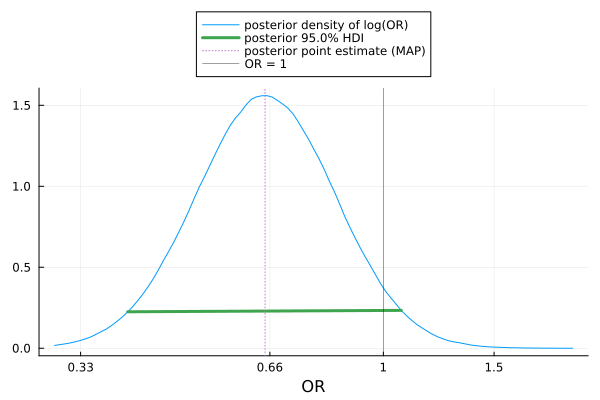

In [4]:
P = print_and_show_results_or_bayes(; prior_logOR=Flat(), xlim_OR=(0.3, 2.0), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])), N=10^5)

logOR_flatprior = copy(globalbox[1])
ik_logOR_flatprior = InterpKDE(kde(logOR_flatprior))
f_flatprior(x) = pdf(ik_logOR_flatprior, x)

P

prior data settin: OR = 1.0,  sample size = 0
prior data: [0 0; 0 0]
new   data: [40 100; 53 87]
posterior P-values of OR ≤ 1, 0.9, 0.8, 0.67: (0.95, 0.892, 0.78, 0.531)
posterior P-values of OR = 1, 0.9, 0.8, 0.67: (0.099, 0.217, 0.439, 0.937)
posterior 95.0% confidence interval of OR: [0.399, 1.08]
posterior point estimate (MLE) of OR: 0.657


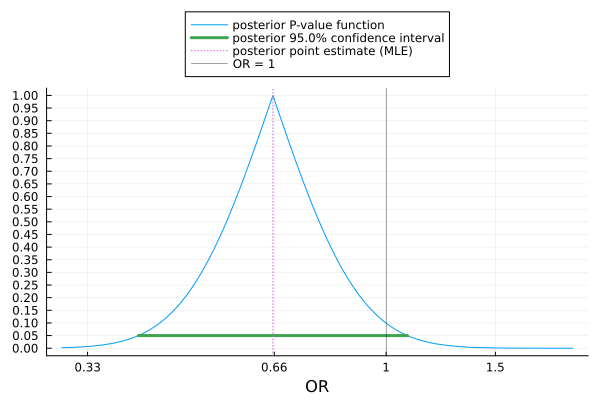

In [5]:
print_and_show_results_or_pvalue(; prior_data_setting=(OR0=1.0, n0=0), xlim_OR=(0.3, 2.0), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])))

┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:01


prior of log(OR): Normal{Float64}(μ=0.0, σ=0.5)
new data: [40 100; 53 87]
posterior probabilities of OR ≤ 1, 0.9, 0.8, 0.67: (0.934, 0.851, 0.699, 0.398)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975): (0.455, 0.61, 0.711, 0.828, 1.11)
posterior 95.0% HDI: [0.455, 1.11]
posterior point estimate (MAP): 0.711


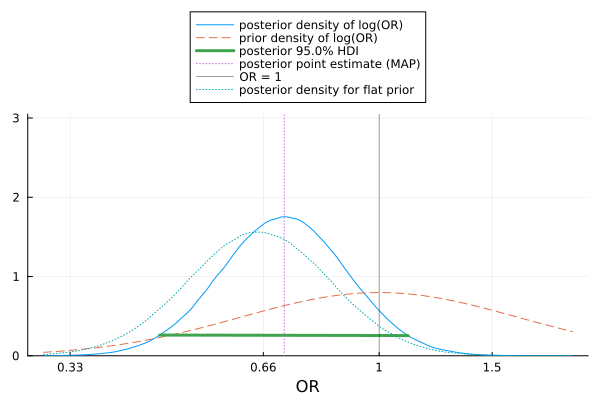

In [6]:
print_and_show_results_or_bayes(; prior_logOR=Normal(log(1.0), 1/2), xlim_OR=(0.3, 2.0), ylim=(0.0, 3.05), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])), N=10^5)
plot!(f_flatprior; label="posterior density for flat prior", ls=:dot)

prior data settin: OR = 1.0,  sample size = 30
prior data: [11 19; 11 19]
new   data: [40 100; 53 87]
posterior P-values of OR ≤ 1, 0.9, 0.8, 0.67: (0.932, 0.849, 0.698, 0.401)
posterior P-values of OR = 1, 0.9, 0.8, 0.67: (0.136, 0.302, 0.604, 0.802)
posterior 95.0% confidence interval of OR: [0.453, 1.11]
posterior point estimate (MLE) of OR: 0.71


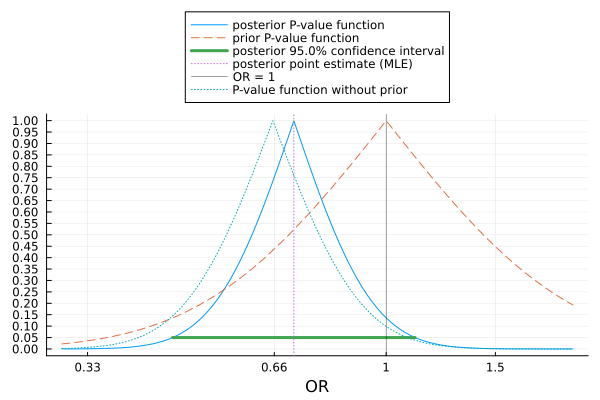

In [7]:
print_and_show_results_or_pvalue(; prior_data_setting=(OR0=1.0, n0=30), xlim_OR=(0.3, 2.0), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])))

┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.4
┌ Info: Found initial step size
└   ϵ = 0.4
Sampling (10 threads): 100%|████████████████████████████| Time: 0:00:00


prior of log(OR): Normal{Float64}(μ=0.0, σ=0.16666666666666666)
new data: [40 100; 53 87]
posterior probabilities of OR ≤ 1, 0.9, 0.8, 0.67: (0.824, 0.568, 0.25, 0.0255)
posterior quantiles of (0.025, 0.25, 0.5, 0.75, 0.975): (0.669, 0.8, 0.879, 0.965, 1.15)
posterior 95.0% HDI: [0.669, 1.15]
posterior point estimate (MAP): 0.881


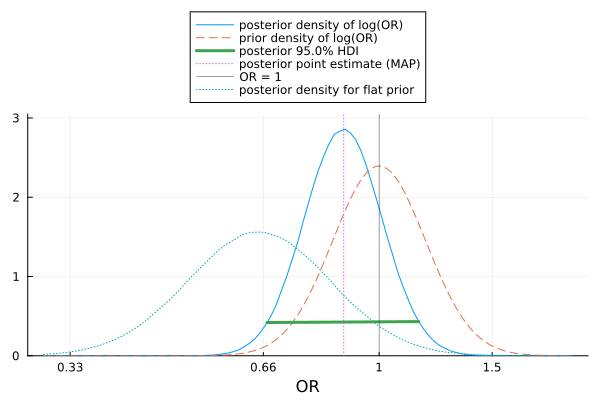

In [8]:
print_and_show_results_or_bayes(; prior_logOR=Normal(log(1.0), 1/6), xlim_OR=(0.3, 2.0), ylim=(0.0, 3.05), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])), N=10^5)
plot!(f_flatprior; label="posterior density for flat prior", ls=:dot)

prior data settin: OR = 1.0,  sample size = 300
prior data: [114 186; 114 186]
new   data: [40 100; 53 87]
posterior P-values of OR ≤ 1, 0.9, 0.8, 0.67: (0.819, 0.563, 0.248, 0.0256)
posterior P-values of OR = 1, 0.9, 0.8, 0.67: (0.363, 0.874, 0.495, 0.0513)
posterior 95.0% confidence interval of OR: [0.669, 1.16]
posterior point estimate (MLE) of OR: 0.88


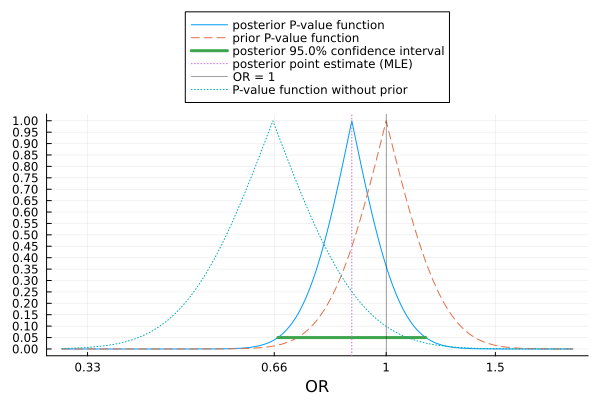

In [9]:
print_and_show_results_or_pvalue(; prior_data_setting=(OR0=1.0, n0=300), xlim_OR=(0.3, 2.0), xtick_OR=([0.33, 0.66, 1, 1.5], string.(Any[0.33, 0.66, 1, 1.5])))